# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [4]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"


#### Important: Restart the Kernel before you move on to the next step.

In [5]:
# Install requirements
!python -m pip install -r requirements.txt

In [4]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.21.0
ipykernel        : 6.29.2
ipywidgets       : 8.1.2
jupyter_client   : 8.6.0
jupyter_core     : 5.7.1
jupyter_server   : 2.12.5
jupyterlab       : 4.1.1
nbclient         : 0.9.0
nbconvert        : 7.16.0
nbformat         : 5.9.2
notebook         : 7.1.0
qtconsole        : 5.5.1
traitlets        : 5.14.1


## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define the data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


# Create the training dataset
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)

# Define the training DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=28, shuffle=True)

# Create the test dataset
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Define the test DataLoader
test_loader = DataLoader(dataset=test_data, batch_size=28, shuffle=False)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

Normalization is the process of scaling input data to a common range, which is often done before feeding data into a neural network. The key reason for normalizing data is to ensure that all input features are on a similar scale. This helps stabilize the gradient descent process, allowing for the use of larger learning rates or enabling the model to converge more quickly with a given learning rate.

While strictly speaking, normalization is not always required when input variables are combined linearly, as in a multilayer perceptron (MLP), there are practical benefits. Normalizing the inputs can speed up training and reduce the risk of the model getting stuck in local optima. It also simplifies the application of techniques like weight decay and Bayesian estimation.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
# This cell contains a function for showing 5 images from a dataloader
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

0


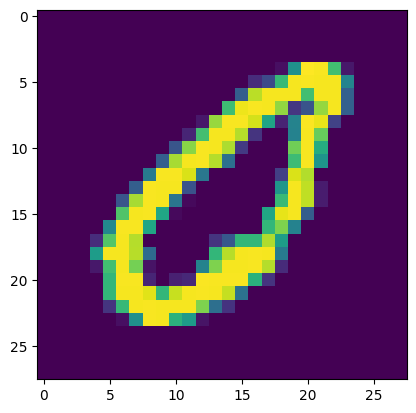

6


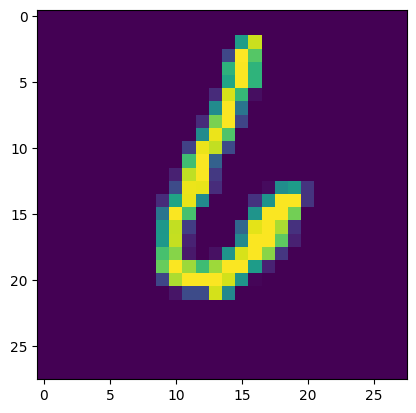

9


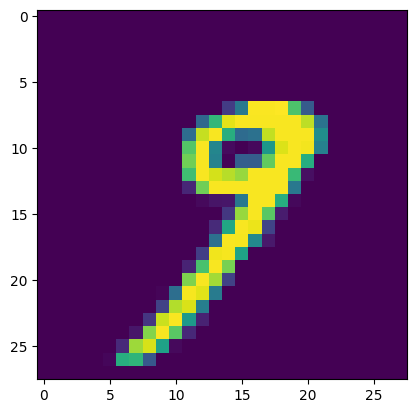

2


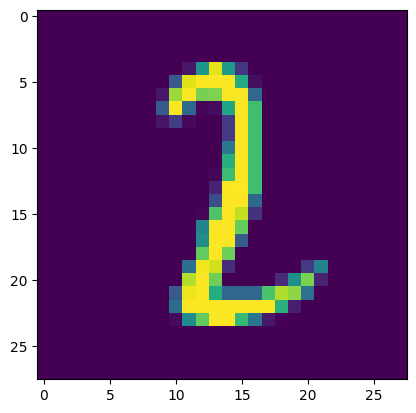

3


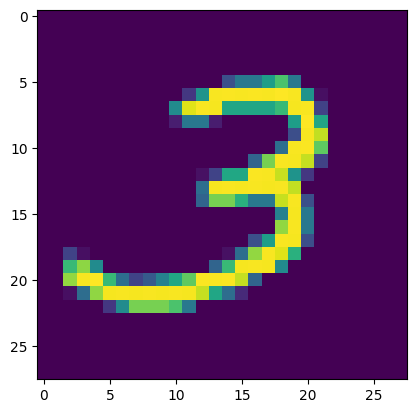

1


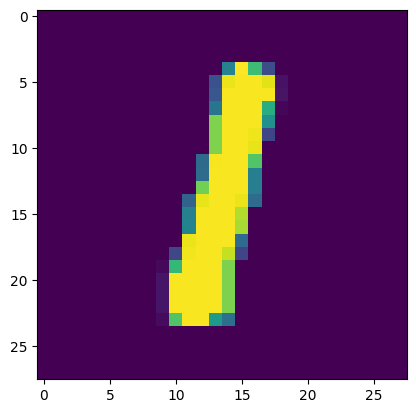

6


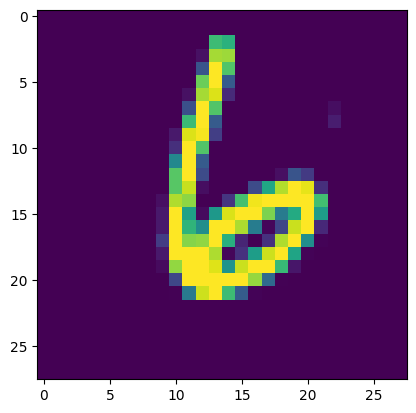

4


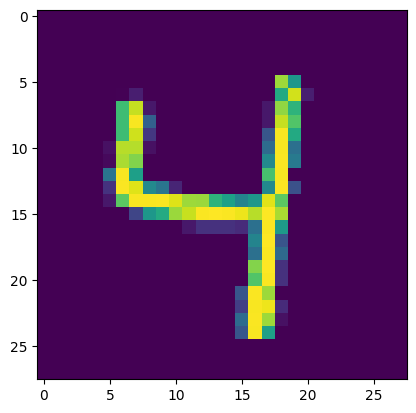

2


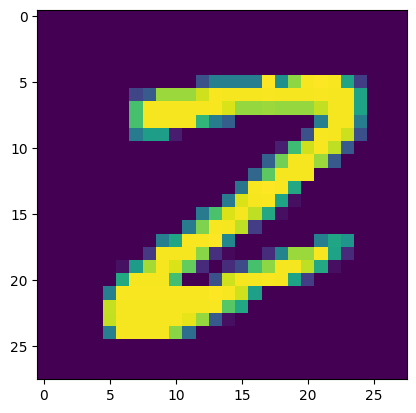

0


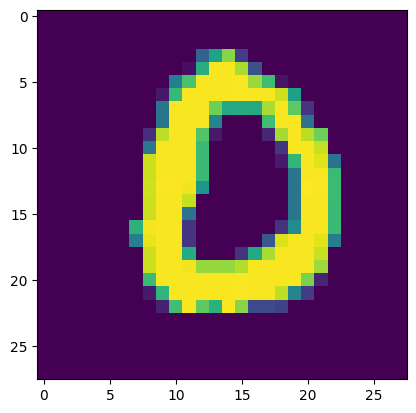

In [9]:
# Explore data - Displays the size and shape of training and test data
transform_raw = transforms.Compose([transforms.ToTensor()])

# Load raw training data
training_data_raw = datasets.MNIST(root="data", train=True, download=True, transform=transform_raw)
train_loader_raw = DataLoader(training_data_raw, batch_size=30, shuffle=True)

# Display sample images from the training data
show5(train_loader_raw)

# Load raw testing data
testing_data_raw = datasets.MNIST(root="data", train=False, download=True, transform=transform_raw)
test_loader_raw = DataLoader(testing_data_raw, batch_size=30, shuffle=True)

# Display sample images from the test data
show5(test_loader_raw)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define activation function
        self.activation = F.relu
        
        # Define dropout layer with 50% probability of zeroing out neurons
        self.dropout = nn.Dropout(p=0.5)
        
        # Define fully connected layers with correct input size for MNIST (28x28 = 784)
        self.fc1 = nn.Linear(28 * 28 * 1, 118)  # First layer: input size is 784
        self.fc2 = nn.Linear(118, 86)           # Second layer: hidden size to next hidden size
        self.fc3 = nn.Linear(86, 10)            # Third layer: hidden size to output size (10 classes)

    def forward(self, x):
        # Apply dropout to input (no specific size requirements)
        x = self.dropout(x)
        
        # Flatten the input, keeping the batch dimension intact
        x = torch.flatten(x, start_dim=1)
        
        # Forward pass through the network
        x = self.activation(self.fc1(x))
        x = self.dropout(x)  # Apply dropout again after the first layer
        
        x = self.activation(self.fc2(x))
        
        # Final output layer (without activation)
        x = self.fc3(x)
        return x
#instantiate the model 
#define net
net = Net()
net.to(device)

#print model's state_dict
print("Model state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t, net,state_dict()[param_tensor].size()")

Model state_dict:
fc1.weight 	, net,state_dict()[param_tensor].size()
fc1.bias 	, net,state_dict()[param_tensor].size()
fc2.weight 	, net,state_dict()[param_tensor].size()
fc2.bias 	, net,state_dict()[param_tensor].size()
fc3.weight 	, net,state_dict()[param_tensor].size()
fc3.bias 	, net,state_dict()[param_tensor].size()


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
# Define the Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Alternatively, you could use SGD as follows:
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

# Print the optimizer's state_dict
print("Optimizer's state_dict:")
for key in optimizer.state_dict():
    print(f"{key} \t {optimizer.state_dict()[key]}")

# Specify the loss function
criterion = nn.CrossEntropyLoss()


Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5]}]


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
# Function to train the model
train_loss_history = []
val_loss_history = []

def train_model(net, optimizer, criterion, train_loader, num_epochs):
    
    best_val_loss = float('inf')  # Initialize the best validation loss to infinity for tracking improvement
    threshold = 0.001             # Minimum performance improvement threshold to monitor
    below_threshold = 0           # Counter for consecutive epochs below the improvement threshold
    patience = 2                  # Maximum number of epochs to allow the model to perform below threshold before stopping

    for epoch in range(num_epochs):
        
        # Training phase
        net.train()                # Set model to training mode
        train_loss = 0.0           # Initialize the running training loss for the epoch
        train_correct = 0          # Initialize the correct prediction counter for training

        for i, data in enumerate(train_loader):  # Iterate over batches in train_loader
            
            inputs, labels = data                   # Unpack the inputs and labels
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device (GPU/CPU)
            optimizer.zero_grad()                   # Zero the parameter gradients
            outputs = net(inputs)                   # Perform forward pass (get model outputs)
            loss = criterion(outputs, labels)       # Compute the loss based on predictions and actual labels
            loss.backward()                         # Compute gradients via backpropagation
            optimizer.step()                        # Update model parameters using the optimizer
            
            _, preds = torch.max(outputs.data, 1)   # Get the predictions (class with max probability)
            train_correct += (preds == labels).sum().item()  # Count correct predictions
            train_loss += loss.item()               # Accumulate loss for the current batch

        # Print training results for the epoch
        print(f'Epoch {epoch + 1} training accuracy: {train_correct / len(train_loader.dataset):.2f}% '
              f'training loss: {train_loss / len(train_loader):.5f}')
        
        # Record training loss history
        train_loss_history.append(train_loss / len(train_loader))

        # Validation phase
        val_loss = 0.0            # Initialize the running validation loss
        val_correct = 0           # Initialize the correct prediction counter for validation
        net.eval()                # Set model to evaluation mode (no gradient calculations)

        with torch.no_grad():     # Disable gradient computation for validation
            for inputs, labels in train_loader:  # Iterate over batches (could be 'validation_loader' if using 3-way split)
                
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to appropriate device
                outputs = net(inputs)                                  # Perform forward pass
                loss = criterion(outputs, labels)                      # Compute the loss
                _, preds = torch.max(outputs.data, 1)                  # Get predictions
                val_correct += (preds == labels).sum().item()          # Count correct predictions
                val_loss += loss.item()                                # Accumulate loss for the current batch

        # Print validation results for the epoch
        print(f'Epoch {epoch + 1} validation accuracy: {val_correct / len(train_loader.dataset):.2f}% '
              f'validation loss: {val_loss / len(train_loader):.5f}')
        
        # Record validation loss history
        val_loss_history.append(val_loss / len(train_loader))

        # Calculate the difference between the current and best validation loss
        diff = best_val_loss - val_loss

        # Update the best validation loss if the current loss is smaller
        if best_val_loss > val_loss:
            best_val_loss = val_loss

        # Track if performance is below the improvement threshold
        if diff <= threshold:
            below_threshold += 1
            if below_threshold > patience:  # Stop training if patience is exceeded
                break


In [8]:
# Train the model
train_model(net, optimizer, criterion, train_loader, num_epochs = 10)

Epoch 1 training accuracy: 0.76% training loss: 0.72377
Epoch 1 validation accuracy: 0.91% validation loss: 0.28670
Epoch 2 training accuracy: 0.82% training loss: 0.55240
Epoch 2 validation accuracy: 0.92% validation loss: 0.26333
Epoch 3 training accuracy: 0.83% training loss: 0.51161
Epoch 3 validation accuracy: 0.94% validation loss: 0.21113
Epoch 4 training accuracy: 0.84% training loss: 0.48546
Epoch 4 validation accuracy: 0.93% validation loss: 0.21805
Epoch 5 training accuracy: 0.85% training loss: 0.46862
Epoch 5 validation accuracy: 0.94% validation loss: 0.20204
Epoch 6 training accuracy: 0.85% training loss: 0.45844
Epoch 6 validation accuracy: 0.95% validation loss: 0.19745
Epoch 7 training accuracy: 0.86% training loss: 0.44861
Epoch 7 validation accuracy: 0.95% validation loss: 0.18136
Epoch 8 training accuracy: 0.86% training loss: 0.44377
Epoch 8 validation accuracy: 0.94% validation loss: 0.19254
Epoch 9 training accuracy: 0.86% training loss: 0.43152
Epoch 9 validati

Plot the training loss (and validation loss/accuracy, if recorded).

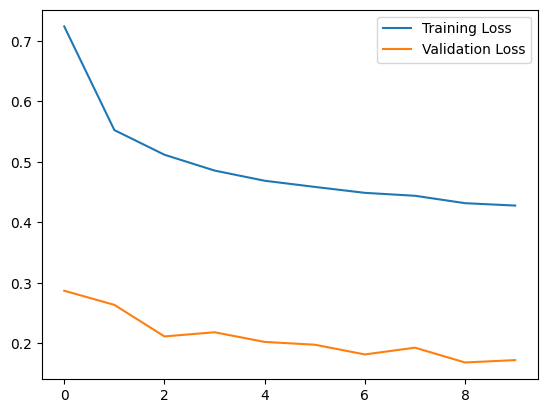

In [9]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

Epoch 1/10 | Test Accuracy: 95.25% | Test Loss: 0.16784
Epoch 2/10 | Test Accuracy: 95.25% | Test Loss: 0.16784
Epoch 3/10 | Test Accuracy: 95.25% | Test Loss: 0.16784
Epoch 4/10 | Test Accuracy: 95.25% | Test Loss: 0.16784
Epoch 5/10 | Test Accuracy: 95.25% | Test Loss: 0.16784
Epoch 6/10 | Test Accuracy: 95.25% | Test Loss: 0.16784
Epoch 7/10 | Test Accuracy: 95.25% | Test Loss: 0.16784
Epoch 8/10 | Test Accuracy: 95.25% | Test Loss: 0.16784
Epoch 9/10 | Test Accuracy: 95.25% | Test Loss: 0.16784
Epoch 10/10 | Test Accuracy: 95.25% | Test Loss: 0.16784


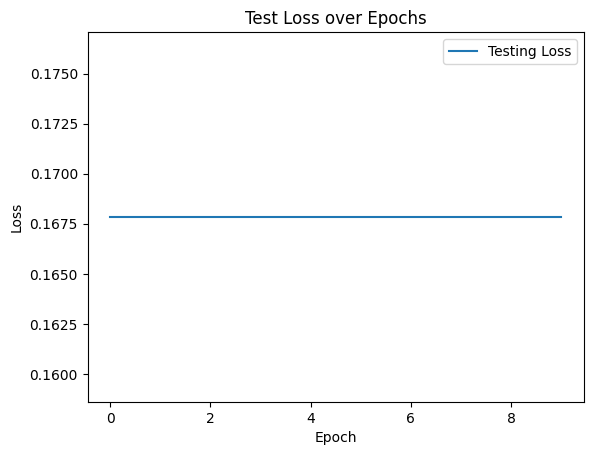

In [11]:
# Perform testing across specified number of epochs
num_epochs = 10

# List to store test loss history for plotting later
test_loss_history = []

for epoch in range(num_epochs):
    test_loss = 0.0  # Initialize cumulative test loss for the epoch
    test_correct = 0  # Initialize correct predictions count
    net.eval()  # Set the model to evaluation mode (disables dropout, etc.)

    # Loop over batches in the test data
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device (GPU/CPU)
        outputs = net(inputs)  # Forward pass: compute model outputs
        loss = criterion(outputs, labels)  # Compute the loss using the criterion
        _, preds = torch.max(outputs.data, 1)  # Get predictions (the index of the max logit)
        test_correct += (preds == labels).sum().item()  # Count correct predictions in the batch
        test_loss += loss.item()  # Accumulate the loss for this batch

    # Compute accuracy and average test loss for the current epoch
    epoch_accuracy = test_correct / len(test_loader.dataset) * 100
    epoch_loss = test_loss / len(test_loader)

    # Log the results for the epoch
    print(f'Epoch {epoch + 1}/{num_epochs} | Test Accuracy: {epoch_accuracy:.2f}% | Test Loss: {epoch_loss:.5f}')

    # Append the average test loss for plotting
    test_loss_history.append(epoch_loss)

# Plotting the test loss over epochs
plt.plot(test_loss_history, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test Loss over Epochs")
plt.legend()
plt.show()


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [12]:
## YOUR CODE HERE ##
# Define the SGD optimizer with a learning rate of 0.01, momentum of 0.9, and weight decay of 1e-5
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

# Display the optimizer's state_dict
print("Optimizer's state_dict:")
for key, value in optimizer.state_dict().items():
    print(f"{key}: {value}")

# Set up the loss function using CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Train the model for 10 epochs using the defined optimizer, loss function, and train loader
train_model(net, optimizer, criterion, train_loader, num_epochs=10)


Optimizer's state_dict:
state: {}
param_groups: [{'lr': 0.01, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 1e-05, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5]}]
Epoch 1 training accuracy: 0.84% training loss: 0.53490
Epoch 1 validation accuracy: 0.94% validation loss: 0.21436
Epoch 2 training accuracy: 0.84% training loss: 0.53502
Epoch 2 validation accuracy: 0.95% validation loss: 0.20757
Epoch 3 training accuracy: 0.84% training loss: 0.52413
Epoch 3 validation accuracy: 0.95% validation loss: 0.20441
Epoch 4 training accuracy: 0.84% training loss: 0.52490
Epoch 4 validation accuracy: 0.94% validation loss: 0.24223
Epoch 5 training accuracy: 0.84% training loss: 0.52350
Epoch 5 validation accuracy: 0.94% validation loss: 0.23032
Epoch 6 training accuracy: 0.84% training loss: 0.51911
Epoch 6 validation accuracy: 0.94% validation loss: 0.21434


## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
# Save the model's state_dict for future loading
model_save_path = "trained_model_state.pth"
torch.save(net.state_dict(), model_save_path)
print(f"Model state_dict saved to {model_save_path}")


Model state_dict saved to trained_model_state.pth
